## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score
from sklearn.metrics import SCORERS
# from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from code.functions import *
# %matplotlib inline

# EDA

## Load Data

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [4]:
df.hus_ocu.value_counts()

3    585
1    436
2    425
4     27
Name: hus_ocu, dtype: int64

## Feature Engineering

49 0.16295261509293898


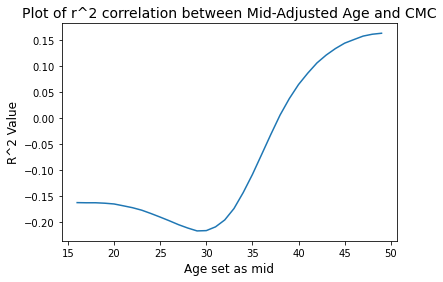

In [5]:
df_age = df.copy()
r_values = {}
ages = range(df_age.age.min(), df_age.age.max() + 1)
for age in ages:
    df_age['age_mid'] = np.abs(df_age['age'] - age)
    r_values[age] = df_age['age_mid'].corr(df_age.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Age and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Age set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

0 0.08277224205909448


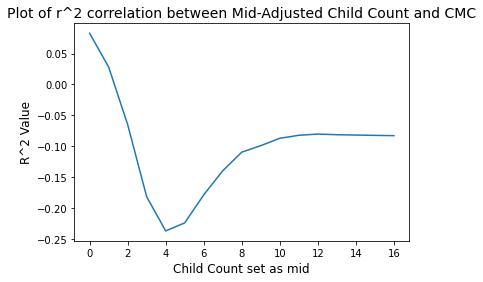

In [6]:
df_child = df.copy()
r_values = {}
childs = range(df_child.chil.min(), df_child.chil.max() + 1)
for child in childs:
    df_child['chil_mid'] = np.abs(df_child.chil - child)
    r_values[child] = df_child['chil_mid'].corr(df_child.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Child Count and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Child Count set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

## Dummying, Scaling/Fit/Transform

In [7]:
X = df.copy()
y = X.pop('cmc')
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums.shape
X_train_df, X_test, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
# X_train.shape
rs = RobustScaler()
rs.fit(X_train_df)
X_train = rs.transform(X_train_df)
X_test = rs.transform(X_test)

# Modeling

Best model from model fit :

# Predicting on new data

In [8]:
columns_1987 = ['v012', 'v106', 'v701', 'v201', 'v130', 'v714', 'v705', 'v109', 'v110', 'v111', 'v312']
columns_2017 = ['v012', 'v106', 'v701', 'v201', 'v130', 'v714', 'v705', 'v157', 'v158', 'v159', 'v312']
cmc_map = {'not using':'1', 'iud':'2', 'pill':'3', 'injections':'3', 'female sterilization':'2', 'condom':'3',
           'periodic abstinence':'3', 'withdrawal':'3', 'jamu jamu (herbs)':'3', 'abstinence':'3', 'norplant':'2',
           'pijat (massage)':'3', 'male sterilization':'2', 'other':'3', 'diaphragm /foam/jelly':'3',
           'injections 3 month':'3', 'injection 1 months':'3', 'implants/norplant':'2', 'other traditional':'3',
           'lactational amenorrhea (lam)':'3', 'other modern method':'3', 'male condom':'3'}
# rel_map = {'muslim':1, 'hindu':0, 'protestant /christian':0, 'catholic':0, 'buddhist':0, 'other':0}
ocu_map = {'agriculture':'4', 'manual':'3', 'sales, services':'2', 'prof, tech, cleric.':'1', 'never worked':'5',
          'other':'5', 'dont know':'5', 'agricultural - self employed':'4', 'industrial worker':'3', 'services':'2',
          'sales':'2', 'professional/technical/managerial':'1', 'clerical':'1', 'did not work':'5', 'don\'t know':'5'}

## Load full 1987 Data

In [9]:
df_1987_ir = pd.read_stata('data/ID_1987_DHS_04012021_1716_161452/IDIR01DT/IDIR01FL.DTA', columns = columns_1987)
df_1987_ir.dropna(subset=['v312'], inplace=True)
# df_1987_ir.dropna(subset=['v130'], inplace=True)
df_1987_ir.drop(columns=['v130'], inplace=True)
df_1987_ir.shape

(11883, 10)

In [10]:
# ['age','edu','hus_edu','chil','rel','work', 'hus_ocu','sol','media','cmc']

In [11]:
df_1987_ir.head()

,v012,v106,v701,v201,v714,v705,v109,v110,v111,v312
0,41,secondary,primary,6,yes,agriculture,no,no,yes,not using
1,27,secondary,secondary,5,no,"prof, tech, cleric.",yes,yes,no,not using
2,43,secondary,secondary,8,no,"sales, services",yes,yes,no,not using
3,41,primary,secondary,9,yes,"prof, tech, cleric.",no,yes,yes,not using
4,29,secondary,secondary,3,no,agriculture,yes,yes,yes,not using


In [12]:
conditions = [(df_1987_ir.v109 == 'yes'), 
              (df_1987_ir.v110 == 'yes'),
              (df_1987_ir.v111 == 'yes')           
]

choices = [1, 1, 1]

df_1987_ir['vmed'] = np.select(conditions, choices, 0)
df_1987_ir.vmed.value_counts()

1    9407
0    2476
Name: vmed, dtype: int64

In [13]:
df_1987_ir.v312 = df_1987_ir.v312.map(cmc_map)
# df_1987_ir.v130 = df_1987_ir.v130.map(rel_map)
df_1987_ir.v312.value_counts()

1    6267
3    3256
2    2360
Name: v312, dtype: int64

In [14]:
df_1987_ir.v705 = df_1987_ir.v705.map(ocu_map)
df_1987_ir.v705.value_counts()

4    4858
3    2943
2    2106
1    1847
5     127
Name: v705, dtype: int64

In [15]:
df_1987_ir['uses_cm'] = np.where(df_1987_ir.v312 == '1', # mapping multiclass target to a boolean Yes/No value
                            0,
                            1)

In [16]:
X_1987 = df_1987_ir.copy()
y_1987 = X_1987.pop('uses_cm')
y_1987 = y_1987.astype(int)
X_1987.v201 = X_1987.v201.astype(object)
X_1987.vmed = X_1987.vmed.astype(object)
X_1987.drop(columns = ['v109','v110','v111','v312'], inplace = True)

In [17]:
X_1987.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11883 entries, 0 to 11883
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   v012    11883 non-null  int8    
 1   v106    11883 non-null  category
 2   v701    11877 non-null  category
 3   v201    11883 non-null  object  
 4   v714    11867 non-null  category
 5   v705    11881 non-null  object  
 6   vmed    11883 non-null  object  
dtypes: category(3), int8(1), object(3)
memory usage: 418.2+ KB


In [18]:
y_1987.value_counts()

0    6267
1    5616
Name: uses_cm, dtype: int64

## Modeling using best method

{'lr__C': 206.913808111479, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  39
Model score:  0.6418714237630427
Accuracy score:  0.6418714237630427
Model F1 (micro):  0.6418714237630427
Model F1 (macro):  0.6408297420784181
Model F1 (weighted):  0.6401461384728833
Cross validation score:  [0.62910008 0.60639193 0.61952862 0.58838384 0.56649832]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62      3076
           1       0.61      0.72      0.66      2866

    accuracy                           0.64      5942
   macro avg       0.65      0.64      0.64      5942
weighted avg       0.65      0.64      0.64      5942



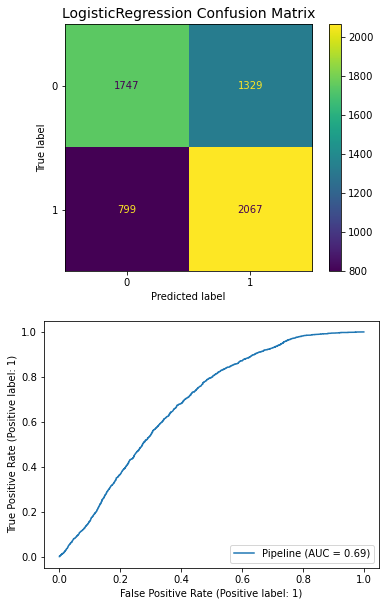

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_1987, y_1987, test_size=0.5, random_state=729)

# train set
X_train_nums = X_train.select_dtypes('int8')
rs = RobustScaler()
# ss = StandardScaler()
rs.fit(X_train_nums)
nums_df = pd.DataFrame(rs.transform(X_train_nums),
                      index=X_train_nums.index)

X_train_cat = X_train.select_dtypes(['category','object'])
ohe = OneHotEncoder(
    #drop='first',
    handle_unknown='ignore',
    sparse=False)
dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

X_train_clean = pd.concat([nums_df,
                 dums_df], axis=1)
# test set
X_test_nums = X_test.select_dtypes('int8')
nums_df = pd.DataFrame(rs.transform(X_test_nums),
                      index=X_test_nums.index)

X_test_cat = X_test.select_dtypes(['category','object'])
dums_df = pd.DataFrame(ohe.transform(X_test_cat),
                       columns=ohe.get_feature_names(),
                       index=X_test_cat.index)
X_test_clean = pd.concat([nums_df,
                 dums_df], axis=1)

new_pipe_lr = Pipeline([('lr', LogisticRegression(random_state=1, max_iter=200))])

params_grid_new_lr = {'lr__penalty' : ['l2'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  #'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                     }

new_lr_clf = GridSearchCV(new_pipe_lr, param_grid = params_grid_new_lr,
                       cv = 3, verbose=0, n_jobs=-1, scoring='recall')

new_lr_clf.fit(X_train_clean, y_train)
print(new_lr_clf.best_params_)
best_new_lr_clf = new_lr_clf.best_estimator_
model_stats(X_train_clean.columns, best_new_lr_clf, 'LogisticRegression', X_test_clean, y_test, 'True')

In [20]:
y_test

7573     1
2962     1
8825     0
6303     1
5376     0
        ..
6479     1
6174     0
2604     0
11554    1
5578     1
Name: uses_cm, Length: 5942, dtype: int64

## Comparing against 2017 data as holdout set

In [21]:
df_2017_ir = pd.read_stata('data/ID_2017_DHS_04012021_1713_161452/IDIR71DT/IDIR71FL.DTA', columns = columns_2017)
df_2017_ir.drop(columns=['v130'], inplace=True)
df_2017_ir.dropna(subset=['v701','v714','v705', 'v157', 'v158', 'v159'], inplace=True)
# df_1987_ir.dropna(subset=['v130'], inplace=True)
df_2017_ir.shape

(34245, 10)

In [22]:
df_2017_ir.isna().sum()

v012    0
v106    0
v701    0
v201    0
v714    0
v705    0
v157    0
v158    0
v159    0
v312    0
dtype: int64

In [23]:
df_2017_ir.v157.value_counts()

not at all               20174
less than once a week    10786
at least once a week      3285
Name: v157, dtype: int64

In [24]:
conditions = [df_2017_ir.v157 != 'not at all',
              df_2017_ir.v158 != 'not at all',
              df_2017_ir.v159 != 'not at all']
choices = [1, 1, 1]

df_2017_ir['vmed'] = np.select(conditions, choices, 0)
df_2017_ir.vmed.value_counts()

1    33046
0     1199
Name: vmed, dtype: int64

In [25]:
df_2017_ir.v312 = df_2017_ir.v312.map(cmc_map)
df_2017_ir.v312.value_counts()

3    16328
1    13464
2     4453
Name: v312, dtype: int64

In [26]:
df_2017_ir['uses_cm'] = np.where(df_2017_ir.v312 == '1', # mapping multiclass target to a boolean Yes/No value
                            0,
                            1)
df_2017_ir.uses_cm.value_counts()

1    20781
0    13464
Name: uses_cm, dtype: int64

In [27]:
df_2017_ir.v705 = df_2017_ir.v705.map(ocu_map)
df_2017_ir.v705.value_counts()

2    10150
4     9378
3     8454
1     5419
5      844
Name: v705, dtype: int64

In [28]:
X_2017 = df_2017_ir.copy()
y_2017 = X_2017.pop('uses_cm')
y_2017 = y_2017.astype(int)
X_2017.v201 = X_2017.v201.astype(object)
X_2017.vmed = X_2017.vmed.astype(object)
X_2017.drop(columns = ['v157','v158','v159','v312'], inplace = True)

In [29]:
X_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34245 entries, 0 to 49626
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   v012    34245 non-null  int8    
 1   v106    34245 non-null  category
 2   v701    34245 non-null  category
 3   v201    34245 non-null  object  
 4   v714    34245 non-null  category
 5   v705    34245 non-null  object  
 6   vmed    34245 non-null  object  
dtypes: category(3), int8(1), object(3)
memory usage: 1.2+ MB


In [30]:
X_2017_nums = X_2017.select_dtypes('int8')
nums_df = pd.DataFrame(rs.transform(X_2017_nums),
                      index=X_2017_nums.index)

X_2017_cat = X_2017.select_dtypes(['category','object'])
dums_df = pd.DataFrame(ohe.transform(X_2017_cat),
                       columns=ohe.get_feature_names(),
                       index=X_2017_cat.index)
X_2017_clean = pd.concat([nums_df,
                 dums_df], axis=1)

Classifier:  LogisticRegression
Num features:  39
Model score:  0.6332311286319171
Accuracy score:  0.6332311286319171
Model F1 (micro):  0.6332311286319171
Model F1 (macro):  0.6244481730634552
Model F1 (weighted):  0.6367194898277163
Cross validation score:  [0.68812965 0.68871368 0.68112133 0.64169952 0.63235509]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.61      0.57     13464
           1       0.72      0.65      0.68     20781

    accuracy                           0.63     34245
   macro avg       0.62      0.63      0.62     34245
weighted avg       0.64      0.63      0.64     34245



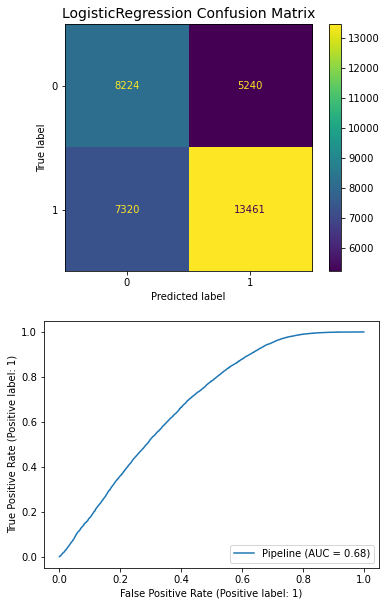

In [31]:
y_2017_pred = best_new_lr_clf.predict(X_2017_clean)
model_stats(X_2017_clean.columns, best_new_lr_clf, 'LogisticRegression', X_2017_clean, y_2017, 'True')